In [2]:
'''Train a simple deep CNN on the CIFAR10 small images dataset.
It gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.
(it's still underfitting at that point, though).
'''

from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
batch_size = 32
num_classes = 10
epochs = 20
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [4]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.summary()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
con

In [5]:
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

Using real-time data augmentation.


In [10]:
    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

Epoch 1/20
1563/1563 [==============================] - 281s 179ms/step - loss: 1.5651 - acc: 0.4273 - val_loss: 1.3957 - val_acc: 0.4989
Epoch 2/20
1563/1563 [==============================] - 327s 209ms/step - loss: 1.4556 - acc: 0.4731 - val_loss: 1.3095 - val_acc: 0.5241
Epoch 3/20
1563/1563 [==============================] - 323s 207ms/step - loss: 1.3689 - acc: 0.5075 - val_loss: 1.1795 - val_acc: 0.5807
Epoch 4/20
1563/1563 [==============================] - 310s 199ms/step - loss: 1.3046 - acc: 0.5342 - val_loss: 1.2177 - val_acc: 0.5651
Epoch 5/20
 379/1563 [======>.......................] - ETA: 3:24 - loss: 1.2540 - acc: 0.5511

KeyboardInterrupt: 

In [11]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 15s 2ms/step
Test loss: 1.1285421746253967
Test accuracy: 0.6038


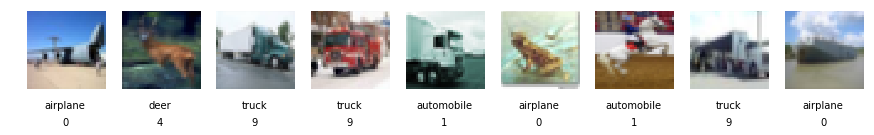

In [12]:
class_mapping = {0 : "airplane", 1 : "automobile", 2 : "bird", 3 : "cat", 4 : "deer", 5 : "dog", 6 : "frog", 7 : "horse", 8 : "ship", 9 : "truck"}

w=10
h=10
fig=plt.figure(figsize=(15, 15))
columns = 9
rows = 1
indices = np.random.randint(len(x_test), size=(10))
labels = np.argmax(model.predict(x_test[indices]), axis=1)
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(x_test[indices[i-1]].reshape((32, 32, 3)))
    plt.axis('off')
    plt.text(15,38, class_mapping[labels[i-1]],  horizontalalignment='center', verticalalignment='center')
    plt.text(15,45, labels[i-1],  horizontalalignment='center', verticalalignment='center')
plt.show()